In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
import os
import numpy as np
import math
from tqdm import tqdm
from sklearn import metrics

In [2]:
def make_data(lst, dim):
    lst=pd.DataFrame(lst)
    lst.columns=['data']
    window=dim
    str='data'
    for i in range(1, window):
        column=f'{str}_lag{i}'
        lst[column]=lst[str].shift(i)
    lst=lst.dropna().reset_index(drop=True)
    return lst.values

def calc_leq(df, unit):
    df.reset_index(inplace=True, drop=True)
    for i in range(int(len(df)/unit)+1):
        hour_df=df.loc[i*unit:(i+1)*unit, 'original'].copy()
        N=len(hour_df)
        Leq=10*np.log10(np.sum(np.power(10, hour_df/10)))-10*np.log10(N)
        df.loc[i*unit:(i+1)*unit, 'leq']=Leq
    return df

def leq_filter(df):
    df=calc_leq(df, 18000)
    df.loc[(df['original']<df['leq']), 'd']=0
    return df

def validate(test_v, anorm, thr):
    test_v['z']=np.where(anorm>=thr, 1, 0)
    test_v.reset_index(inplace=True, drop=True)
    
    #     適合率
    tp=test_v[(test_v['label']==1)&(test_v['z']==1)]
    z_p=test_v[test_v['z']==1]
    
    try:
        pre_score=len(tp)/len(z_p)
    except ZeroDivisionError:
        print(f'閾値{thr}　-->　ZeroDivisionError')
        pre_score=0

    #     再現率
    df_anorm=[]
    search= 1 if test_v.loc[0, 'label']==0 else 0
    start=0
    for num in range(len(test_v)):
        if search==1 and test_v.loc[num, 'label']==search:
            start=num
            search=0
        elif search==0 and test_v.loc[num, 'label']==search:
            stop=num-1
            anorm_range=test_v.loc[start:stop].copy()
            df_anorm.append(anorm_range)
            search=1
            
    count=[]
    for i in range(len(df_anorm)):
        if len(df_anorm[i].loc[df_anorm[i]['z']==1])>=1:
               count.append(i)    

    re_score=len(count)/len(df_anorm)

    return pre_score, re_score

def figure(df_test, anorm, d, thr):
    df_test['z']=np.where(d>=thr, 1, 0)
    
    z=df_test['z'].values*100
    test_plot=df_test['original'].values
    num_ax=math.ceil(len(test_plot)/17999)
    label=df_test['label'].values*100
    label_index=range(len(label))
    time_unit=60
    time=[t*0.2/60 for t in range(len(anorm))]
    plt.rcParams["font.size"] = 30

    fig, ax=plt.subplots(num_ax, 1, figsize=(35, 15*num_ax))
    for i in range(num_ax):
        ax[i].plot(time, anorm, '-r',linewidth = 1 )
        ax[i].plot(time, test_plot, '-k',linewidth = 2)
        ax[i].fill_between(time, label, facecolor='lime' )
        ax[i].fill_between(time, z, facecolor='coral' )
        ax[i].set_ylim(0, 90)
        ax[i].set_xlim(i*time_unit, time_unit*(i+1))
        ax[i].set_xticks(np.arange(60*i, 60*(i+1)))
        ax[i].xaxis.set_tick_params(rotation=70)
    plt.show()
    
def fig_pr(test_v, d, bins):
    bins_1=int(bins*0.8)
    thr_1=np.linspace(d.min(), 0.6, bins_1)
    thr_2=np.linspace(0.6, d.max(), bins-bins_1)
    thresholds=np.concatenate([thr_1, thr_2])
    precision=np.array([])
    recall=np.array([])
    for i in thresholds:
        p, r=validate(test_v, d, i)
        precision=np.append(precision, p)
        recall=np.append(recall, r)

    auc = metrics.auc(recall, precision)
    f_score=(2*precision*recall)/(precision+recall)
    thr=thresholds[np.argmax(f_score)]

    plt.rcParams["font.size"] = 10
    plt.plot(recall, precision, marker='o', markevery=[np.argmax(f_score)], label='PR curve (AUC = %.2f)'%auc)
    plt.legend()
    plt.title('PR curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.show()

    return precision, recall, f_score, thresholds, thr, auc
    
def auc_gs(test_v, d, bins):
    bins_1=int(bins*0.8)
    thr_1=np.linspace(d.min(), 0.6, bins_1)
    thr_2=np.linspace(0.6, d.max(), bins-bins_1)
    thresholds=np.concatenate([thr_1, thr_2])
    precision=np.array([])
    recall=np.array([])
    for i in thresholds:
        p, r=validate(test_v, d, i)
        precision=np.append(precision, p)
        recall=np.append(recall, r)

    auc = metrics.auc(recall, precision)

    return auc

def fig_th_f(thresholds, f_score):
    plt.plot(thresholds, f_score, marker="o", markevery=[np.argmax(f_score)])
    plt.xlabel('thresholds')
    plt.ylabel('f_score')
    plt.grid(True)
    plt.show()
    
    return thresholds[np.argmax(f_score)], f_score.max()

In [3]:
df = pd.read_csv( os.path.join('filtered_csv_label', 'learning_data_10.csv') )
df=df[df['day']<=9]
df

original  label  time  day
0            53.4      0    15    0
1            52.8      0    15    0
2            52.8      0    15    0
3            53.2      0    15    0
4            53.6      0    15    0
...           ...    ...   ...  ...
3995345      45.9      0     5    9
3995346      45.6      0     5    9
3995347      45.8      0     5    9
3995348      45.7      0     5    9
3995349      45.9      0     5    9

[3995350 rows x 4 columns]

## ホールドアウト法
### 訓練、検証、テストへ分割
* 検証（チューニング用）：0日目
* テスト（最終評価用）：1 日目
#### （※特異スペクトル変換は訓練データ必要なし）

In [4]:
valid_day=[0]
test_day=[1]

test=df[(df['day'].isin(test_day))].reset_index(drop=True)
valid=df[df['day'].isin(valid_day)].reset_index(drop=True)

## グリッドサーチ
### チューニング

In [5]:
#特徴量とラベルに分割
valid_x = valid['original']
valid_y = valid['label']

In [ ]:
w_list=[1, 2, 4, 6, 8]
l_list=[1, 2, 4, 6, 8]
d_list=[0, 1, 2, 3, 4, 5]

best_score=0

for w in tqdm(w_list):
    for l in l_list:
        for d in d_list:
            #それぞれ（テスト、履歴）の直行行列の最初のm列目までを使う
            m = 2
            #データ数
            T = len(valid_x)
            sv = [0 for i in range(0, T)]
            for s in range(l+w-1, T-d, l+w-1):
                H1 = make_data(valid_x[s-w-l+1:s].values, w).T
                Htest = make_data(valid_x[s-w-l+1+d:s+d].values, w).T
                U1 =  np.linalg.svd(H1)[0]
                U2 =  np.linalg.svd(Htest)[0]
                e  =  np.linalg.svd(np.dot(U1[:, 0:m].T , U2[:, 0:m]))[1]
                ab = e[0]
                sv[s] = (1 - ab*ab)
            sv=np.array(sv)

            test_v=valid.copy()[['original', 'label']]
            test_v['d']=sv 
            
            #道路交通騒音に埋もれている異常音は正常とする
            test_v=leq_filter(test_v)
            test_v['d']=test_v['d']/test_v['d'].max()
            sv=test_v['d'].values
            
            target_v=test_v[l+w-1::l+w-1].copy().reset_index(drop=True)
            target_sv=sv[l+w-1::l+w-1]

#             target_v=test_v.copy()
#             target_sv=sv.copy()
            
            #AUC計算
            thr_bins=50
            auc = auc_gs(target_v, target_sv, thr_bins)
            
            if auc>best_score:
                best_score=auc
                best_params={'w':w, 'l':l, 'd':d}
                print(f'更新AUC：{best_score}')
print('==================================================================')
print(f'AUC最高：{best_score}')
print(f'パラメータ：{best_params}')

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisionError
閾値nan　-->　ZeroDivisi

# チューニング結果
* w_list=[6, 10, 14, 18, 22]
* l_list=[6, 10, 14, 18, 22]
* d_list=[0, 3, 6, 10, 14, 18, 22]
​
## →best_params={'w': 6, 'l': 6, 'd': 3}
## →best_AUC=0.519539404617263
=============================================================  
* w_list=[1, 2, 4, 6, 8]
* l_list=[1, 2, 4, 6, 8]
* d_list=[0, 1, 2, 3, 4, 5]
## →best_params=
## →best_AUC=
=============================================================  

## =========最終結果==========
## best_params=

## 最終評価

In [9]:
# best_params={'w': 6, 'l': 6, 'd': 3}

In [10]:
#特徴量とラベルに分割
test_x = test['original']
test_y = test['label']

In [11]:
#窓幅（列数）
w =best_params['w']
#行数
l = best_params['l']
#テスト行列と履歴行列をどれだけずらすか
d =best_params['d']
#それぞれ（テスト、履歴）の直行行列の最初のm列目までを使う
m = 2
#データ数
T = len(test_x)
sv = [0 for i in range(0, T)]

In [12]:
for s in range(l+w-1, T-d, l+w-1):
    H1 = make_data(test_x[s-w-l+1:s].values, w).T
    Htest = make_data(test_x[s-w-l+1+d:s+d].values, w).T
    U1 =  np.linalg.svd(H1)[0]
    U2 =  np.linalg.svd(Htest)[0]
    e  =  np.linalg.svd(np.dot(U1[:, 0:m].T , U2[:, 0:m]))[1]
    print ('e', e)
    ab = e[0]
    sv[s] = (1 - ab*ab)

e [0.99999936 0.27921783]
e [0.99999578 0.74937441]
e [0.9999982  0.27145681]
e [0.99999943 0.19417275]
e [0.99999973 0.08654454]
e [0.99999943 0.11798359]
e [0.99999945 0.2459839 ]
e [0.99999965 0.96462351]
e [0.9999999  0.01575099]
e [0.99999647 0.70394763]
e [0.99999779 0.97504186]
e [0.99999973 0.1797538 ]
e [0.9999985  0.17095826]
e [0.99999956 0.31613188]
e [0.99999885 0.35073146]
e [0.99999782 0.07904368]
e [0.9999991  0.13981254]
e [0.99998806 0.74821836]
e [0.99999972 0.16410308]
e [0.99999894 0.30862544]
e [0.99999972 0.63499168]
e [0.99999945 0.45104092]
e [0.99999897 0.63292882]
e [0.99999973 0.46068392]
e [0.99999943 0.84832796]
e [0.99999956 0.22509757]
e [0.99999946 0.28908178]
e [0.99999953 0.59053435]
e [0.99999489 0.2997946 ]
e [0.99999901 0.49495669]
e [0.99999855 0.37354843]
e [0.99999953 0.19393016]
e [0.99999949 0.05539919]
e [0.99999839 0.6697225 ]
e [0.99999931 0.3103545 ]
e [0.99999979 0.41610337]
e [0.99999973 0.04310629]
e [0.99999978 0.68113976]
e [0.9999998

e [0.99998897 0.74568431]
e [0.99998558 0.34337775]
e [0.99995805 0.42035557]
e [0.99999312 0.09203904]
e [0.99999871 0.04112434]
e [0.99999882 0.92406232]
e [0.9999965  0.92199935]
e [0.99998873 0.09502269]
e [0.99999105 0.31191736]
e [0.99999797 0.04026824]
e [0.99999978 0.00691449]
e [0.99999689 0.36879487]
e [0.99999928 0.85160405]
e [0.9999986  0.82826411]
e [0.99999959 0.36728498]
e [0.99999952 0.47538284]
e [0.99999963 0.07816051]
e [0.99999718 0.28898552]
e [0.99999904 0.15496368]
e [0.99999828 0.21006078]
e [0.99999845 0.49952638]
e [0.99999928 0.18357163]
e [0.99999146 0.94508868]
e [0.99999901 0.11731629]
e [0.99999745 0.79574066]
e [0.9999999  0.92667936]
e [0.99999976 0.11334745]
e [0.99999968 0.26948591]
e [0.99999969 0.07126955]
e [0.99999893 0.71824813]
e [0.99999709 0.09536713]
e [0.99999818 0.90942445]
e [0.99999941 0.30955652]
e [0.9999996  0.04424469]
e [0.99999956 0.30881948]
e [0.9999986 0.274828 ]
e [0.99999762 0.0139686 ]
e [0.9999973  0.90151583]
e [0.99999974 

e [0.99999891 0.1681796 ]
e [0.99999923 0.08115619]
e [0.99999169 0.93795832]
e [0.99999957 0.94633464]
e [0.99999916 0.61034507]
e [0.99999759 0.43109719]
e [0.99999755 0.06000078]
e [0.99998093 0.20289935]
e [0.9999888  0.16138193]
e [0.99999951 0.25834427]
e [0.99999906 0.76044269]
e [0.99999863 0.07628029]
e [0.99999856 0.22803437]
e [0.99999787 0.805653  ]
e [0.99999868 0.32911317]
e [0.99999911 0.15614592]
e [0.99999823 0.92388831]
e [0.99999755 0.37582058]
e [0.99999741 0.93873095]
e [0.99999816 0.53333511]
e [0.99998842 0.98894934]
e [0.99998937 0.72909776]
e [0.99999866 0.93836382]
e [0.99999474 0.44941308]
e [0.99999513 0.60931479]
e [0.99998203 0.90286822]
e [0.99999532 0.34809723]
e [0.99999913 0.46512987]
e [0.9999866  0.33602697]
e [0.99999786 0.14232955]
e [0.99999455 0.87615789]
e [0.99999311 0.73905708]
e [0.99999822 0.85275667]
e [0.99999796 0.65983005]
e [0.99999697 0.50892142]
e [0.99999865 0.26762841]
e [0.99999839 0.68287679]
e [0.99999704 0.20561846]
e [0.9999986

e [0.9999995  0.14493883]
e [0.99999338 0.08225429]
e [0.9999179  0.09415009]
e [0.99999219 0.80125931]
e [0.99999411 0.55359298]
e [0.99984703 0.84106742]
e [0.99948038 0.92934159]
e [0.9999792  0.61313554]
e [0.99999946 0.88421108]
e [0.99999882 0.99141096]
e [0.99999249 0.49430671]
e [0.99999793 0.24764443]
e [0.99999916 0.47688703]
e [0.9999985  0.20711581]
e [0.99999917 0.76480747]
e [0.99999848 0.40570495]
e [0.9999936 0.1687352]
e [0.99999662 0.05101946]
e [0.99999717 0.32039852]
e [0.99999604 0.73278305]
e [0.99999944 0.92339401]
e [0.99999891 0.01832735]
e [0.99999978 0.07912555]
e [0.99999305 0.61130864]
e [0.999997   0.52784491]
e [0.99999864 0.02776965]
e [0.99999905 0.06222833]
e [0.99998464 0.76392228]
e [0.99999881 0.08465377]
e [0.99999372 0.78589866]
e [0.99999269 0.80274854]
e [0.99999563 0.44898214]
e [0.99999914 0.19634254]
e [0.99983623 0.53903336]
e [0.99990604 0.92000463]
e [0.9999846  0.41537039]
e [0.99994247 0.04570527]
e [0.99994339 0.92017512]
e [0.99991014 

e [0.99999829 0.04284566]
e [0.99999978 0.73639842]
e [0.99999537 0.25316666]
e [0.99999742 0.80072204]
e [0.99998665 0.72468745]
e [0.99999809 0.70694326]
e [0.99999762 0.20116534]
e [0.99999383 0.49078072]
e [0.99999929 0.23374991]
e [0.99999863 0.1259749 ]
e [0.9999993  0.19243323]
e [0.99999848 0.95011723]
e [0.99999559 0.78939568]
e [0.99999741 0.03809345]
e [0.99999958 0.21493169]
e [0.99999762 0.22572104]
e [0.99999901 0.7234105 ]
e [0.99999944 0.12917992]
e [0.99999718 0.86384141]
e [0.99999381 0.3214891 ]
e [0.9996446  0.79659313]
e [0.99999858 0.22393373]
e [0.9999962  0.08368304]
e [0.99999891 0.25762965]
e [0.99999326 0.37884923]
e [0.999999   0.65583121]
e [0.99999937 0.11828695]
e [0.99999395 0.74977317]
e [0.99999821 0.23396044]
e [0.999998   0.88866968]
e [0.99998905 0.29979392]
e [0.99998164 0.21516514]
e [0.99999401 0.09546497]
e [0.99999967 0.69834806]
e [0.99999868 0.31902208]
e [0.99999936 0.53029186]
e [0.99999839 0.01020749]
e [0.9999991  0.00786498]
e [0.9999852

e [0.99999967 0.33862476]
e [0.99999957 0.8748903 ]
e [0.99999691 0.54020277]
e [0.99999926 0.81222422]
e [0.99999571 0.13271175]
e [0.99999963 0.57420572]
e [0.99999974 0.40276997]
e [0.9999994  0.05639447]
e [0.99999893 0.89512958]
e [0.99999901 0.91632662]
e [0.99998997 0.90833545]
e [0.99999834 0.02640135]
e [0.99999964 0.61392733]
e [0.99999972 0.22850431]
e [0.99999912 0.84182441]
e [0.99998848 0.57390665]
e [0.99999902 0.64423513]
e [0.99999958 0.68935596]
e [0.9999988  0.53004257]
e [0.99999949 0.47288325]
e [0.9999945  0.55719777]
e [0.99999954 0.28485613]
e [0.99999946 0.61991136]
e [0.99999938 0.27570122]
e [0.99999818 0.84201332]
e [0.99999911 0.18953605]
e [0.99999923 0.19495598]
e [0.99999671 0.57227574]
e [0.99999968 0.92002878]
e [0.99999936 0.35739685]
e [0.99999955 0.38582073]
e [0.99999649 0.75175976]
e [0.99999956 0.4021759 ]
e [0.99999684 0.99126718]
e [0.99999958 0.51257337]
e [0.99999872 0.77071821]
e [0.99999926 0.98587893]
e [0.99999882 0.34795394]
e [0.9999922

e [0.99999767 0.2721327 ]
e [0.99998615 0.86298899]
e [0.9999887  0.84877684]
e [0.99999941 0.58734316]
e [0.9999954  0.00357608]
e [0.99999967 0.54127048]
e [0.99999927 0.12686792]
e [0.99999709 0.69939773]
e [0.9999998  0.06762094]
e [0.99999981 0.04409751]
e [0.99999859 0.1311937 ]
e [0.99999893 0.27706758]
e [0.99999448 0.57370071]
e [0.99999927 0.78637224]
e [0.99999835 0.95263388]
e [0.99999704 0.98705486]
e [0.99999786 0.68014138]
e [0.99999573 0.83699563]
e [0.99999954 0.48117374]
e [0.99999958 0.6980336 ]
e [0.99999616 0.66405605]
e [0.99999918 0.02032139]
e [0.99999958 0.02298995]
e [0.9999933  0.77783619]
e [0.99999678 0.62876777]
e [0.99999886 0.95360383]
e [0.99999975 0.79181   ]
e [0.99999754 0.60850438]
e [0.99999923 0.14380204]
e [0.99999704 0.69441884]
e [0.99999954 0.36121774]
e [0.9999997  0.63662886]
e [0.99999818 0.14221491]
e [0.99999884 0.6119965 ]
e [0.99999874 0.78168157]
e [0.9999995  0.79302541]
e [0.99999823 0.40415079]
e [0.9999973  0.87625876]
e [0.9999997

e [0.99999631 0.19623188]
e [0.99999785 0.32918135]
e [0.9999968  0.65935398]
e [0.99999954 0.63662262]
e [0.99999723 0.36620457]
e [0.9999986  0.15247787]
e [0.99999818 0.94963882]
e [0.99999431 0.84106339]
e [0.99999676 0.5897041 ]
e [0.99999722 0.88026428]
e [0.99999877 0.08271819]
e [0.99998605 0.54256842]
e [0.99999894 0.09656769]
e [0.99999706 0.42299399]
e [0.9999993  0.81897736]
e [0.99999857 0.10977028]
e [0.9999993  0.20337074]
e [0.99999906 0.37570526]
e [0.99999719 0.6517805 ]
e [0.99999505 0.31983007]
e [0.99999895 0.27007104]
e [0.99999358 0.15686479]
e [0.99999669 0.22920037]
e [0.99999864 0.12680645]
e [0.99997845 0.08265815]
e [0.99999549 0.56642522]
e [0.99999969 0.3338428 ]
e [0.99999736 0.51992306]
e [0.99999927 0.27259136]
e [0.9999933  0.07004619]
e [0.99999544 0.38874681]
e [0.99999977 0.52019291]
e [0.99999949 0.03095266]
e [0.99998919 0.04425717]
e [0.99999807 0.82923487]
e [0.99999957 0.0662552 ]
e [0.99999904 0.02422386]
e [0.99999921 0.97967304]
e [0.9999975

e [0.99996785 0.11032926]
e [0.99999916 0.39108477]
e [0.99999795 0.65454264]
e [0.99999707 0.58685789]
e [0.99998992 0.26135767]
e [0.99999454 0.93895146]
e [0.99999499 0.4165991 ]
e [0.99999589 0.94633508]
e [0.99999756 0.22339109]
e [0.99998027 0.87839612]
e [0.99999821 0.03322715]
e [0.99999957 0.6548477 ]
e [0.99999914 0.87555802]
e [0.9999975  0.21024018]
e [0.99993856 0.84560957]
e [0.99999897 0.87103525]
e [0.99999969 0.08138408]
e [0.99999941 0.22704418]
e [0.99999516 0.0384492 ]
e [0.99999861 0.74123829]
e [0.99999937 0.71154807]
e [0.99999772 0.19699402]
e [0.99999884 0.56103817]
e [0.99999905 0.56320361]
e [0.9999972  0.46973278]
e [0.99999962 0.69799606]
e [0.99998985 0.67413132]
e [0.99974465 0.54742257]
e [0.99999672 0.91599669]
e [0.9999995  0.73357778]
e [0.99999959 0.14191179]
e [0.99999783 0.02842753]
e [0.99999567 0.99155948]
e [0.99999516 0.11775317]
e [0.99999908 0.07673331]
e [0.99999809 0.63216545]
e [0.99999726 0.27300743]
e [0.99999454 0.23790731]
e [0.9999876

e [0.99999882 0.91899347]
e [0.9999987  0.25298128]
e [0.9999957  0.90751289]
e [0.99999642 0.22543155]
e [0.99999853 0.83654078]
e [0.99999976 0.54175287]
e [0.99999744 0.20244022]
e [0.99999307 0.76617478]
e [0.99997674 0.96239419]
e [0.99999782 0.86597394]
e [0.99999919 0.00672527]
e [0.99999787 0.07355269]
e [0.99999895 0.86759564]
e [0.99999821 0.23675654]
e [0.99999964 0.36436542]
e [0.99999901 0.50206538]
e [0.99997691 0.17188252]
e [0.99999706 0.3584571 ]
e [0.99996967 0.89312672]
e [0.99999809 0.3242209 ]
e [0.99999742 0.13692142]
e [0.99998189 0.56267568]
e [0.99999682 0.09966597]
e [0.99991528 0.79775051]
e [0.99999852 0.88031396]
e [0.99999635 0.34118751]
e [0.9999979  0.52364972]
e [0.99999961 0.65523226]
e [0.9999983  0.95599373]
e [0.99999269 0.95323426]
e [0.9999976  0.40697325]
e [0.99998716 0.90621251]
e [0.99999896 0.6738857 ]
e [0.999999   0.14286069]
e [0.99999663 0.2987239 ]
e [0.99999464 0.45356569]
e [0.99999968 0.90779902]
e [0.9999988  0.39363214]
e [0.9999994

e [0.99999812 0.02481586]
e [0.99999541 0.82908945]
e [0.99999487 0.39146482]
e [0.99999707 0.58522072]
e [0.99999857 0.64026956]
e [0.99999946 0.12701377]
e [0.9999984  0.72270665]
e [0.99996315 0.59088191]
e [0.99998666 0.80325395]
e [0.99999807 0.57003693]
e [0.99998518 0.99057798]
e [0.9999814  0.74775646]
e [0.99998989 0.2236834 ]
e [0.99999969 0.6936024 ]
e [0.99999602 0.16540816]
e [0.99999975 0.78877884]
e [0.99999322 0.30407493]
e [0.99999365 0.50246908]
e [0.99999756 0.92854727]
e [0.99999818 0.21069468]
e [0.99999853 0.32604635]
e [0.99999963 0.8728278 ]
e [0.99999879 0.25226644]
e [0.9999927  0.50552652]
e [0.99999226 0.94046084]
e [0.99999985 0.91017412]
e [0.99999954 0.62521794]
e [0.99999903 0.96678841]
e [0.99999971 0.7275892 ]
e [0.99999651 0.02261841]
e [0.9999993  0.87820475]
e [0.99999626 0.34341341]
e [0.99998701 0.97129025]
e [0.99999903 0.08894822]
e [0.99996347 0.97675185]
e [0.99998923 0.93354643]
e [0.99999878 0.54976558]
e [0.99999901 0.03458853]
e [0.9999978

e [0.99999969 0.95126959]
e [0.99999966 0.16191306]
e [0.99999922 0.7297223 ]
e [0.99999989 0.78381258]
e [0.99999962 0.30292106]
e [0.9999996  0.10002635]
e [0.99999926 0.18033915]
e [0.9999998  0.42356084]
e [0.99999936 0.0468151 ]
e [0.99999981 0.08613342]
e [0.99999951 0.29372981]
e [0.99999956 0.63277821]
e [0.99999752 0.75515792]
e [0.99999902 0.73102843]
e [0.9999993 0.914361 ]
e [0.9999995 0.9880855]
e [0.99999974 0.16786602]
e [0.99999688 0.02564363]
e [0.99999894 0.08337425]
e [0.99999878 0.17068319]
e [0.9999989  0.70219265]
e [0.99999951 0.70818632]
e [0.99999819 0.19409342]
e [0.99999962 0.81189308]
e [0.99999968 0.86345159]
e [0.99999377 0.9903493 ]
e [0.99999832 0.20279725]
e [0.99999945 0.26558212]
e [0.9999986  0.14087217]
e [0.9999978  0.36727516]
e [0.9999934  0.66516724]
e [0.99998678 0.95647895]
e [0.99999741 0.69871644]
e [0.99997938 0.85388215]
e [0.99999875 0.89844732]
e [0.99999385 0.6722866 ]
e [0.99999843 0.04049356]
e [0.99999916 0.33995731]
e [0.99998534 0.

e [0.99999047 0.83889365]
e [0.99997964 0.33248603]
e [0.99985954 0.8144565 ]
e [0.99998776 0.15745786]
e [0.99990952 0.92006974]
e [0.99999282 0.77580579]
e [0.99998069 0.40556854]
e [0.99999708 0.10692683]
e [0.9999997  0.03716379]
e [0.9999958  0.98950337]
e [0.99999614 0.98294867]
e [0.99999852 0.01163578]
e [0.99996298 0.98608119]
e [0.99968932 0.17736538]
e [0.99997009 0.05935737]
e [0.99991373 0.74364991]
e [0.999976   0.11199129]
e [0.99997628 0.82665708]
e [0.99999138 0.1416312 ]
e [0.99999639 0.90363467]
e [0.99999294 0.41960948]
e [0.99991395 0.81798472]
e [0.99997878 0.70175149]
e [0.99999057 0.21763819]
e [0.99999636 0.67946015]
e [0.99999803 0.21453976]
e [0.99999903 0.61804646]
e [0.99973008 0.78406456]
e [0.99995762 0.82866645]
e [0.99988269 0.86258295]
e [0.99997399 0.34536067]
e [0.99999468 0.24175545]
e [0.99999486 0.74949698]
e [0.99999458 0.46391782]
e [0.9999971  0.10604128]
e [0.99998764 0.30920294]
e [0.99996111 0.11750118]
e [0.99985692 0.96410889]
e [0.9998826

e [0.99997182 0.34590288]
e [0.99999885 0.01032417]
e [0.99999981 0.24712538]
e [0.99999645 0.17533924]
e [0.99999639 0.45839572]
e [0.9999955  0.90056352]
e [0.9999948  0.82624943]
e [0.99999767 0.51944244]
e [0.9999751  0.71690666]
e [0.99999637 0.96740448]
e [0.99999739 0.07876322]
e [0.99989059 0.0906747 ]
e [0.99999004 0.19238647]
e [0.99998077 0.14530126]
e [0.99999229 0.01416256]
e [0.99999412 0.51523058]
e [0.99999907 0.1814848 ]
e [0.99999258 0.11608235]
e [0.99999875 0.01129068]
e [0.99999262 0.20262746]
e [0.99996769 0.00933205]
e [0.99999903 0.27344778]
e [0.99999751 0.11040445]
e [0.99999641 0.94969835]
e [0.99998204 0.69322776]
e [0.99998196 0.10195939]
e [0.99999949 0.32979184]
e [0.99999745 0.96174838]
e [0.99997305 0.41452637]
e [0.99979936 0.23904618]
e [0.99999664 0.72073181]
e [0.99999713 0.97391895]
e [0.99999668 0.08938876]
e [0.9999993  0.96996347]
e [0.99999921 0.77936942]
e [0.99999634 0.56579823]
e [0.99999945 0.67169559]
e [0.99999958 0.28306433]
e [0.9999990

e [0.99999875 0.95302109]
e [0.99999813 0.90290519]
e [0.99999942 0.94909392]
e [0.99999972 0.31891925]
e [0.99999875 0.13964757]
e [0.9999345  0.20201308]
e [0.99999505 0.69467977]
e [0.99999763 0.60989081]
e [0.99999893 0.681889  ]
e [0.99999838 0.49236141]
e [0.99999937 0.33356264]
e [0.99999968 0.33616598]
e [0.99999773 0.76339021]
e [0.99999833 0.80705195]
e [0.99999427 0.56356414]
e [0.99999893 0.31937305]
e [0.99999648 0.43463839]
e [0.9999985  0.34198731]
e [0.99999023 0.88151094]
e [0.99999696 0.21523272]
e [0.99998019 0.95883101]
e [0.99999786 0.13302269]
e [0.99999571 0.97202382]
e [0.99999634 0.04342394]
e [0.9999957  0.96536954]
e [0.99999883 0.82966558]
e [0.99999976 0.87519913]
e [0.9999907 0.8616576]
e [0.99999584 0.66434328]
e [0.99999901 0.57273828]
e [0.99999874 0.45488564]
e [0.99999753 0.59388735]
e [0.99999886 0.55673249]
e [0.99999927 0.96039997]
e [0.999998   0.15664103]
e [0.99999119 0.83348472]
e [0.99999501 0.23071498]
e [0.99999673 0.48013564]
e [0.99999711 

e [0.99997054 0.73127462]
e [0.99997509 0.9173983 ]
e [0.99999035 0.21082755]
e [0.99999959 0.27605587]
e [0.99999431 0.80388393]
e [0.99999547 0.05418122]
e [0.99999912 0.04404861]
e [0.99999897 0.98309329]
e [0.9999907  0.32996403]
e [0.99999217 0.93755496]
e [0.99999598 0.66177216]
e [0.999988   0.18155102]
e [0.99997931 0.92766354]
e [0.99999614 0.67130936]
e [0.99997162 0.99077593]
e [0.99997672 0.71332849]
e [0.99999874 0.97421643]
e [0.99999879 0.81859637]
e [0.99999426 0.44896821]
e [0.99997981 0.51700194]
e [0.99999386 0.88506255]
e [0.99999586 0.37028591]
e [0.99999971 0.15940514]
e [0.99999979 0.85277692]
e [0.99999792 0.79287922]
e [0.99999236 0.01359225]
e [0.99997765 0.95813057]
e [0.99999524 0.02435645]
e [0.99999529 0.03801838]
e [0.99999826 0.09430102]
e [0.99999967 0.62938995]
e [0.99999868 0.8106952 ]
e [0.99999933 0.68450057]
e [0.99999522 0.97553367]
e [0.99999958 0.33895447]
e [0.99999008 0.07739346]
e [0.99999592 0.45247658]
e [0.99999371 0.40289443]
e [0.9999960

e [0.99999565 0.29235756]
e [0.99997701 0.74010087]
e [0.999998   0.44255103]
e [0.99999548 0.66905786]
e [0.99999949 0.35461797]
e [0.9999492  0.82347861]
e [0.99993718 0.98244515]
e [0.99999784 0.36192037]
e [0.99999578 0.33571999]
e [0.99999941 0.56692087]
e [0.99999389 0.14488437]
e [0.99998986 0.77052558]
e [0.99999253 0.67230556]
e [0.99998978 0.25141113]
e [0.99999894 0.6206952 ]
e [0.99999831 0.10552   ]
e [0.99999941 0.96249308]
e [0.99998304 0.10130973]
e [0.99999718 0.72425724]
e [0.99999687 0.51954211]
e [0.99999877 0.91000517]
e [0.99999561 0.41498139]
e [0.99999177 0.44286406]
e [0.99999848 0.17510859]
e [0.99999921 0.70671709]
e [0.99999789 0.02772177]
e [0.99999783 0.62980808]
e [0.99999521 0.97040757]
e [0.99997443 0.52333202]
e [0.9999998  0.54446808]
e [0.99999822 0.35181922]
e [0.99998881 0.90888721]
e [0.99999749 0.08549875]
e [0.99999862 0.72872786]
e [0.99997299 0.94685013]
e [0.99999691 0.84033589]
e [0.99999915 0.85860167]
e [0.99999576 0.80407919]
e [0.9999991

e [0.99999805 0.11685648]
e [0.99999966 0.62107261]
e [0.99999681 0.35417481]
e [0.99999971 0.36960772]
e [0.99999827 0.44124396]
e [0.99999414 0.56616386]
e [0.99999931 0.52967369]
e [0.99999465 0.29364945]
e [0.99999823 0.0765371 ]
e [0.9999994  0.15750625]
e [0.99999838 0.13904998]
e [0.99999968 0.15191029]
e [0.99999428 0.93154322]
e [0.99998622 0.82044103]
e [0.99999973 0.82869681]
e [0.99999715 0.67506657]
e [0.99999661 0.16664261]
e [0.9999988  0.31436652]
e [0.99999925 0.48117898]
e [0.99999879 0.84639581]
e [0.99999961 0.09986705]
e [0.99999837 0.638829  ]
e [0.9999998  0.50041476]
e [0.99999618 0.69463814]
e [0.99999886 0.18388185]
e [0.99999936 0.56912963]
e [0.99999829 0.96895018]
e [0.99999773 0.96388958]
e [0.99999936 0.41908569]
e [0.99999942 0.48065407]
e [0.99999977 0.17093722]
e [0.99999921 0.83316686]
e [0.99999427 0.08751717]
e [0.99999266 0.90342071]
e [0.99999946 0.9401021 ]
e [0.99999876 0.88784512]
e [0.99999951 0.32680683]
e [0.99998214 0.13692928]
e [0.9999995

e [0.99999643 0.04089533]
e [0.99999779 0.97400138]
e [0.99999748 0.22236103]
e [0.999998   0.22471764]
e [0.99999866 0.1584252 ]
e [0.99998621 0.54710542]
e [0.99999966 0.44567622]
e [0.99999939 0.85034784]
e [0.99999227 0.40354939]
e [0.99999849 0.45004914]
e [0.9999996  0.10647522]
e [0.99999894 0.6681635 ]
e [0.99999128 0.5863854 ]
e [0.99999842 0.20535631]
e [0.99999921 0.39209091]
e [0.99999841 0.69592496]
e [0.99999779 0.14341623]
e [0.99999597 0.99607261]
e [0.99999978 0.00620944]
e [0.99999992 0.27741849]
e [0.99999939 0.95794866]
e [0.99999931 0.01211607]
e [0.99999859 0.43691614]
e [0.99999944 0.66051803]
e [0.99999783 0.95059332]
e [0.99999765 0.02813647]
e [0.99999925 0.91821565]
e [0.99999833 0.68008847]
e [0.9999953 0.222799 ]
e [0.99999994 0.85734599]
e [0.99999636 0.0787054 ]
e [0.99999893 0.86220158]
e [0.99999536 0.35065079]
e [0.99999846 0.24195671]
e [0.99999762 0.36722991]
e [0.99999944 0.15501048]
e [0.99999838 0.55639876]
e [0.9999869 0.9353915]
e [0.99993778 0.

e [0.9999895  0.44685091]
e [0.99999349 0.07641292]
e [0.99996963 0.90409907]
e [0.999995   0.30126719]
e [0.99999432 0.92073102]
e [0.99999483 0.93471025]
e [0.99999131 0.53728996]
e [0.99994475 0.59037296]
e [0.99987777 0.62332209]
e [0.99999892 0.93635314]
e [0.99999391 0.19135685]
e [0.99993597 0.17696936]
e [0.99997998 0.15313933]
e [0.99999971 0.41612535]
e [0.99999044 0.88984914]
e [0.99999796 0.70605279]
e [0.99999761 0.37486269]
e [0.99999981 0.1885174 ]
e [0.99999872 0.93292769]
e [0.99999953 0.72448413]
e [0.99999971 0.80407758]
e [0.99999976 0.23038576]
e [0.99999122 0.80017937]
e [0.99999144 0.22952339]
e [0.99997284 0.17877475]
e [0.99990973 0.77122375]
e [0.99999575 0.54142398]
e [0.99999935 0.1660085 ]
e [0.99999543 0.6032691 ]
e [0.99995377 0.51595312]
e [0.99999543 0.54369086]
e [0.99999845 0.92506495]
e [0.99999949 0.09112584]
e [0.99999985 0.78388843]
e [0.99997716 0.45680509]
e [0.99999611 0.47618392]
e [0.9999979  0.17441301]
e [0.99998428 0.09424944]
e [0.9998319

e [0.99999671 0.4647143 ]
e [0.99999743 0.36246624]
e [0.99999207 0.24664452]
e [0.99999731 0.89251099]
e [0.99999584 0.90463306]
e [0.9999996  0.42338451]
e [0.99999832 0.70365295]
e [0.99998604 0.0308804 ]
e [0.99999888 0.56342048]
e [0.999999   0.00961819]
e [0.9999979  0.22959807]
e [0.99999741 0.15214036]
e [0.99999744 0.71645348]
e [0.99999841 0.76979018]
e [0.99999809 0.76115706]
e [0.99999728 0.76224078]
e [0.99999931 0.51003788]
e [0.9999961  0.92276262]
e [0.99999508 0.91932275]
e [0.99999979 0.44129888]
e [0.99999831 0.34549921]
e [0.99998935 0.57030136]
e [0.99999307 0.29004733]
e [0.9999993  0.36469564]
e [0.99999565 0.62990227]
e [0.99980444 0.77896706]
e [0.99995931 0.65463755]
e [0.99999775 0.49104839]
e [0.99999926 0.42694342]
e [0.99999218 0.44322693]
e [0.99999801 0.83570125]
e [0.99999907 0.03503389]
e [0.99999911 0.59800002]
e [0.99999849 0.79980084]
e [0.9999984  0.97006478]
e [0.99999963 0.38414517]
e [0.99999768 0.86577088]
e [0.99999812 0.11991481]
e [0.9999953

e [0.99999575 0.72155676]
e [0.99999775 0.46793773]
e [0.999991   0.19147148]
e [0.99999922 0.68831985]
e [0.99999735 0.37236831]
e [0.99999678 0.05422993]
e [0.99999969 0.27361546]
e [0.99999814 0.33495943]
e [0.99999801 0.64501034]
e [0.99999351 0.7520123 ]
e [0.9999962 0.7239459]
e [0.99999896 0.86010639]
e [0.99998046 0.96809259]
e [0.99999716 0.92272212]
e [0.99998461 0.77962894]
e [9.99994648e-01 9.03678307e-04]
e [0.99999294 0.45096256]
e [0.99997158 0.37000528]
e [0.99999558 0.20540617]
e [0.99999903 0.44928651]
e [0.99999472 0.02707979]
e [0.99999792 0.93914141]
e [0.99998741 0.99050279]
e [0.99998934 0.05618362]
e [0.99998323 0.16067284]
e [0.99996771 0.80313871]
e [0.99999917 0.05474479]
e [0.9999992  0.04233592]
e [0.99999921 0.05636997]
e [0.9999985  0.36240305]
e [0.999984   0.20324349]
e [0.99999948 0.570743  ]
e [0.9999994  0.44908961]
e [0.99999935 0.37568978]
e [0.99999684 0.36664   ]
e [0.99999948 0.26767739]
e [0.99999665 0.51590754]
e [0.99999782 0.91846334]
e [0.9

e [0.99999913 0.70355421]
e [0.99999786 0.93300375]
e [0.99999864 0.85307453]
e [0.99999925 0.38516853]
e [0.9999964  0.01815543]
e [0.99999957 0.44062943]
e [0.99999841 0.52592388]
e [0.99999235 0.92709517]
e [0.99999707 0.9358083 ]
e [0.9999951  0.50537752]
e [0.99999432 0.571944  ]
e [0.99999273 0.38912854]
e [0.99999968 0.45442585]
e [0.99999884 0.33519346]
e [0.99999751 0.81060885]
e [0.99999819 0.69938572]
e [0.99999691 0.13920874]
e [0.99999786 0.03832863]
e [0.99999914 0.66399741]
e [0.99999966 0.58594876]
e [0.99999008 0.99561841]
e [0.99995838 0.99475735]
e [0.99999852 0.7220554 ]
e [0.99999979 0.89752973]
e [0.99999767 0.32500684]
e [0.99999964 0.91148193]
e [0.99999861 0.18686385]
e [0.99999923 0.83024806]
e [0.99999888 0.29779467]
e [0.9999961  0.88295458]
e [0.99999501 0.66499368]
e [0.99999931 0.53862368]
e [0.99999824 0.05425701]
e [0.9999938  0.73458787]
e [0.99999585 0.55384127]
e [0.99998779 0.33724336]
e [0.99999795 0.41798431]
e [0.99999454 0.76846038]
e [0.9999824

e [0.9999997  0.52593971]
e [0.99999888 0.91209017]
e [0.99999895 0.93425066]
e [0.99999663 0.11700089]
e [0.99999625 0.16710357]
e [0.99999798 0.78787875]
e [0.99999906 0.19993425]
e [0.99999874 0.49681148]
e [0.99999989 0.58791768]
e [0.99998655 0.86706334]
e [0.99999922 0.63026255]
e [0.9999894  0.87080774]
e [0.99999957 0.57966336]
e [0.99999855 0.74980753]
e [0.99999286 0.25465964]
e [0.9999741  0.40134691]
e [0.99999921 0.20376641]
e [0.99999819 0.86261445]
e [0.99999812 0.06481644]
e [0.99999969 0.95943766]
e [0.99998919 0.13098846]
e [0.99999982 0.5542257 ]
e [0.99999781 0.08059761]
e [0.99998442 0.05231925]
e [0.99998199 0.59672764]
e [0.99997363 0.84066415]
e [0.99999772 0.23206848]
e [0.99998892 0.98641232]
e [0.99999834 0.15270021]
e [0.99999823 0.78593398]
e [0.99999916 0.91885107]
e [0.99999472 0.0190437 ]
e [0.9999709  0.98950551]
e [0.99999433 0.98587198]
e [0.99999544 0.57954851]
e [0.99998237 0.43520602]
e [0.99999128 0.22113167]
e [0.99992521 0.40117257]
e [0.9999982

e [0.99999537 0.65184441]
e [0.99998858 0.15259109]
e [0.99999854 0.74243775]
e [0.99999249 0.42150447]
e [0.99999653 0.78070914]
e [0.99998456 0.99015618]
e [0.9999979  0.02867628]
e [0.99999705 0.32884291]
e [0.99999645 0.78439343]
e [0.99999892 0.98808593]
e [0.99999826 0.34038568]
e [0.99999928 0.68436656]
e [0.99999992 0.31120702]
e [0.9999936  0.92018224]
e [0.99999627 0.20267449]
e [0.99999895 0.10684855]
e [0.99999927 0.90652913]
e [0.99999776 0.72239901]
e [0.99999749 0.81153335]
e [0.99999775 0.27842706]
e [0.99998243 0.91335789]
e [0.99999944 0.39952568]
e [0.99999758 0.1406383 ]
e [0.99997136 0.91711381]
e [0.99997885 0.57407446]
e [0.99999777 0.66275917]
e [0.99999303 0.14924796]
e [0.9999976  0.20575522]
e [0.99999747 0.37416474]
e [0.99999989 0.36710255]
e [0.99999933 0.50223288]
e [0.9999873  0.98374735]
e [0.9999801  0.63103743]
e [0.99999925 0.15150444]
e [0.99997003 0.49999027]
e [0.99999698 0.3734338 ]
e [0.99999674 0.26828191]
e [0.9999979  0.06574498]
e [0.9999981

e [0.99998199 0.49797185]
e [0.99994797 0.92322969]
e [0.99999424 0.54067152]
e [0.99995874 0.04397063]
e [0.99999904 0.03511604]
e [0.9999865  0.97360738]
e [0.9999838  0.52023273]
e [0.99999765 0.18348171]
e [0.99999968 0.14921822]
e [0.99999911 0.82152013]
e [0.99999616 0.94406464]
e [0.99999913 0.5863058 ]
e [0.99999679 0.16568368]
e [0.99999973 0.04923848]
e [0.99999706 0.87362411]
e [0.99998995 0.00664541]
e [0.99999739 0.34300681]
e [0.99999912 0.786496  ]
e [0.99999891 0.34501572]
e [0.99996821 0.81913736]
e [0.99998403 0.09041494]
e [0.99999804 0.92373256]
e [0.99999955 0.23486093]
e [0.99999657 0.86560522]
e [0.99999886 0.93440939]
e [0.99999931 0.33939555]
e [0.99999803 0.19031042]
e [0.99999816 0.12826305]
e [0.99999254 0.78997936]
e [0.99999813 0.42705759]
e [0.99998879 0.44337262]
e [0.99999914 0.49867081]
e [0.99999695 0.06869118]
e [0.99999814 0.02711382]
e [0.99999798 0.59844695]
e [0.99999875 0.42316632]
e [0.99999921 0.01239692]
e [0.99999975 0.8719449 ]
e [0.9999974

e [0.99999674 0.90448097]
e [0.99999979 0.93373037]
e [0.99999863 0.08663158]
e [0.99999619 0.512324  ]
e [0.99999885 0.61447832]
e [0.99999121 0.21692705]
e [0.99997242 0.85765779]
e [0.99999068 0.72109772]
e [0.99999705 0.42600969]
e [0.99999655 0.02196583]
e [0.99999528 0.25643552]
e [0.99998715 0.06334649]
e [0.99999945 0.88723948]
e [0.99977209 0.52812842]
e [0.99999265 0.79006835]
e [0.99999875 0.07931677]
e [0.99999985 0.72570654]
e [0.99999139 0.37297208]
e [0.99998954 0.11860733]
e [0.9999952  0.15951772]
e [0.99999872 0.05272073]
e [0.99999924 0.65670719]
e [0.9999982  0.14706427]
e [0.99999747 0.83160899]
e [0.99999766 0.8749557 ]
e [0.99999989 0.29748347]
e [0.99999943 0.82390773]
e [0.99999852 0.95607287]
e [0.99999861 0.28164636]
e [0.99999457 0.06465836]
e [0.99999924 0.33983297]
e [0.99999967 0.14656031]
e [0.99999765 0.11910827]
e [0.99999857 0.47231169]
e [0.99999807 0.56690966]
e [0.99999816 0.16094766]
e [0.99999577 0.79306722]
e [0.99999319 0.1708523 ]
e [0.9999997

e [0.99999723 0.35436234]
e [0.99999888 0.41324855]
e [0.99999852 0.60706759]
e [0.99999931 0.47276007]
e [0.99999864 0.79823569]
e [0.99999889 0.27917166]
e [0.99999711 0.84036748]
e [0.99999967 0.29202361]
e [0.99999975 0.63629457]
e [0.99999881 0.12882269]
e [0.99999796 0.85207936]
e [0.9999992  0.97308653]
e [0.99999963 0.76686125]
e [0.99999927 0.686926  ]
e [0.99999881 0.9252363 ]
e [0.99999168 0.03177882]
e [0.99999778 0.8480794 ]
e [0.99999767 0.72736388]
e [0.999994   0.00528557]
e [0.99999748 0.98857571]
e [0.99999991 0.80237137]
e [0.99999859 0.19413372]
e [0.99999839 0.74308291]
e [0.99999974 0.94751034]
e [0.99999843 0.99201258]
e [0.99999703 0.02718373]
e [0.99999982 0.16089339]
e [0.99999924 0.26753819]
e [0.99999881 0.23608891]
e [0.99998969 0.90209145]
e [0.99999376 0.96844025]
e [0.99999906 0.16365799]
e [0.99999782 0.9540752 ]
e [0.99999953 0.93899468]
e [0.9999816  0.45429857]
e [0.99999814 0.49571442]
e [0.99999942 0.18216955]
e [0.99999549 0.92935788]
e [0.9999997

e [0.99998315 0.76399859]
e [0.9999977  0.31815957]
e [0.99999848 0.16795532]
e [0.9999981  0.90496158]
e [0.99999946 0.67834922]
e [0.99999747 0.88491299]
e [0.99999868 0.80960186]
e [0.9999992  0.04297694]
e [0.99999737 0.21816075]
e [0.99999314 0.13499779]
e [0.99998283 0.51125918]
e [0.99999966 0.31275742]
e [0.99999343 0.07813769]
e [0.9999818  0.63080996]
e [0.9999979  0.95962215]
e [0.9999967  0.83965379]
e [0.99999842 0.29262298]
e [0.99999856 0.80590854]
e [0.99999659 0.90135418]
e [0.99999973 0.07482717]
e [0.99999853 0.00727003]
e [0.99999598 0.94596718]
e [0.99999986 0.61302086]
e [0.9999996  0.82803336]
e [0.99999967 0.43062079]
e [0.9999987  0.67912028]
e [0.99999931 0.13246007]
e [0.99999877 0.08240282]
e [0.99999979 0.81292912]
e [0.99999938 0.90001193]
e [0.99999694 0.14243395]
e [0.99999923 0.97175793]
e [0.99999756 0.78590534]
e [0.99999954 0.89635067]
e [0.99999868 0.25749982]
e [0.9999984  0.83400476]
e [0.99995821 0.44440818]
e [0.99999845 0.82800311]
e [0.9999945

e [0.9999968  0.52036545]
e [0.9999992  0.05556559]
e [0.99999727 0.593819  ]
e [0.99999981 0.59655021]
e [0.99999808 0.13961596]
e [0.99999895 0.04176061]
e [0.99999874 0.10802562]
e [0.99999921 0.30619409]
e [0.99999294 0.56653717]
e [0.99999948 0.69595063]
e [0.99999463 0.58589759]
e [0.99999945 0.80721078]
e [0.9999997  0.04172714]
e [0.99999973 0.57713492]
e [0.99999867 0.74810485]
e [0.99999899 0.27633739]
e [0.99999949 0.23996275]
e [0.99999809 0.35768753]
e [0.99999674 0.99274321]
e [0.99999975 0.40146242]
e [0.99999928 0.01043489]
e [0.99999943 0.61630045]
e [0.99999941 0.71949757]
e [0.99999684 0.15419571]
e [0.99999973 0.01386138]
e [0.9999973 0.8486359]
e [0.99999342 0.19271146]
e [0.99999901 0.46497733]
e [0.99999697 0.06066971]
e [0.99999948 0.07811947]
e [0.99999844 0.01234533]
e [0.99999903 0.184347  ]
e [0.99999873 0.6239196 ]
e [0.99999748 0.8073047 ]
e [0.99999242 0.03639498]
e [0.99999563 0.7669617 ]
e [0.99999876 0.43205921]
e [0.99998563 0.15393912]
e [0.99999894 

e [0.99999952 0.71664262]
e [0.99999882 0.91704201]
e [0.99999801 0.19938862]
e [0.99999988 0.51273489]
e [0.99999743 0.95189785]
e [0.999988  0.7012092]
e [0.99999881 0.5578073 ]
e [0.99999836 0.25521946]
e [0.99999796 0.97568012]
e [0.99999793 0.9564822 ]
e [0.99999973 0.21313422]
e [0.9999989  0.07775665]
e [0.99999872 0.73481032]
e [0.99999759 0.81599318]
e [0.99999946 0.72210811]
e [0.99999985 0.45003802]
e [0.99999756 0.59772525]
e [0.99999592 0.74874   ]
e [0.99999862 0.14492564]
e [0.99999967 0.8585318 ]
e [0.99999902 0.40962089]
e [0.99999815 0.768839  ]
e [0.999999   0.23663004]
e [0.99999862 0.67300739]
e [0.99999966 0.93244321]
e [0.99996607 0.15250061]
e [0.99999174 0.07509716]
e [0.99990835 0.59389783]
e [0.99999972 0.09579856]
e [0.9999964  0.73331938]
e [0.9999986  0.39194599]
e [0.99999829 0.10929704]
e [0.99999658 0.72050824]
e [0.99999302 0.35277905]
e [0.9999887  0.30259911]
e [0.99999936 0.1115532 ]
e [0.99999964 0.50052439]
e [0.99999999 0.84990764]
e [0.99999635 

e [0.9999998  0.16090028]
e [0.99999963 0.49177231]
e [0.99999918 0.25143346]
e [0.99999979 0.82941668]
e [0.99999784 0.75114337]
e [0.99999977 0.23676107]
e [0.99999969 0.31194159]
e [0.99999763 0.92725848]
e [0.99999962 0.32108782]
e [0.99997998 0.23216385]
e [0.99999802 0.70604297]
e [0.99999878 0.46190109]
e [0.99999813 0.15635428]
e [0.999999  0.2766236]
e [0.99999779 0.70772142]
e [0.99999746 0.75117085]
e [0.99999921 0.3639271 ]
e [0.99999944 0.06987613]
e [0.99999587 0.70425571]
e [0.9999958  0.68382916]
e [0.99999556 0.93904204]
e [0.99999889 0.44101883]
e [0.99999964 0.11739052]
e [0.99999785 0.77366048]
e [0.99999877 0.00311492]
e [0.99999889 0.41971366]
e [0.99999937 0.86025246]
e [0.99999982 0.26367984]
e [0.99999822 0.81015034]
e [0.99999881 0.93693358]
e [0.99999905 0.0296295 ]
e [0.99999958 0.19546049]
e [0.9999986  0.88313667]
e [0.99999935 0.38563703]
e [0.99999863 0.76715408]
e [0.99999773 0.09513273]
e [0.99999916 0.49001606]
e [0.99999977 0.09826414]
e [0.99999904 

e [0.99999933 0.14348018]
e [0.99999933 0.19202131]
e [0.99999967 0.22398756]
e [0.99999933 0.90437642]
e [0.99999948 0.78506984]
e [0.99999685 0.75827757]
e [0.99999465 0.53513967]
e [0.99999894 0.01908337]
e [0.99999925 0.02739913]
e [0.99999378 0.35789718]
e [0.99999933 0.58032537]
e [0.99999561 0.93730021]
e [0.9999924 0.9680778]
e [0.99999917 0.40354147]
e [0.99999844 0.95870334]
e [0.99999704 0.21043927]
e [0.99999842 0.60048814]
e [0.9999992  0.05442261]
e [0.99998995 0.53521218]
e [0.99999771 0.3122692 ]
e [0.99999989 0.75208841]
e [0.99999967 0.09541243]
e [0.9999987  0.56632274]
e [0.99999089 0.54448985]
e [0.99999723 0.97508188]
e [0.99999932 0.15394847]
e [0.99999916 0.04966804]
e [0.99999953 0.1000492 ]
e [0.99999983 0.24375802]
e [0.99999876 0.75374086]
e [0.99998706 0.88075572]
e [0.99999961 0.26467308]
e [0.99999927 0.73871856]
e [0.99999567 0.98697525]
e [0.99999954 0.6253654 ]
e [0.99999865 0.59734408]
e [0.99999859 0.98808789]
e [0.99999947 0.7059071 ]
e [0.99999891 

e [0.99999918 0.37390416]
e [0.99999932 0.88559759]
e [0.99999619 0.94224262]
e [0.99999789 0.88648413]
e [0.99999991 0.74878289]
e [0.99999984 0.1177223 ]
e [0.99999947 0.49272731]
e [0.99999881 0.52842501]
e [0.99999901 0.80618314]
e [0.99999808 0.4398212 ]
e [0.99999954 0.9403587 ]
e [0.99999939 0.22917389]
e [0.99999748 0.86005534]
e [0.99999836 0.25106562]
e [0.99999775 0.83070353]
e [0.99999178 0.53751964]
e [0.99999863 0.32938675]
e [0.99999186 0.89985308]
e [0.99999987 0.73269597]
e [0.99999933 0.13493803]
e [0.99999794 0.56519232]
e [0.99999833 0.0812938 ]
e [0.99999909 0.48736524]
e [0.99999945 0.32092694]
e [0.99999352 0.79239052]
e [0.99999831 0.90661416]
e [0.99999925 0.74173635]
e [0.99999892 0.88325492]
e [0.99999906 0.37151914]
e [0.99999911 0.3921073 ]
e [0.99999991 0.89892951]
e [0.99999858 0.91835879]
e [0.99999809 0.20960218]
e [0.9999985  0.09188474]
e [0.99999748 0.96189948]
e [0.99999923 0.7181548 ]
e [0.99999581 0.06254245]
e [0.99999962 0.53951304]
e [0.9999996

e [0.99999891 0.25718963]
e [0.99999984 0.39272377]
e [0.99999617 0.83721706]
e [0.99999253 0.48991345]
e [0.99999768 0.52742935]
e [0.99999814 0.05092985]
e [0.99999972 0.40826264]
e [0.99999541 0.35101777]
e [0.99999628 0.77180062]
e [0.99999936 0.95849176]
e [0.99999997 0.63122022]
e [0.99999902 0.13377392]
e [0.9999982  0.22306464]
e [0.99999112 0.71675247]
e [0.99999929 0.00332315]
e [0.99999932 0.26985586]
e [0.99929949 0.93118493]
e [0.99999866 0.12752491]
e [0.99986741 0.12998456]
e [0.99999729 0.69628154]
e [0.99999956 0.48928708]
e [0.99999856 0.42792436]
e [0.99999456 0.73568795]
e [0.99999967 0.94120367]
e [0.99999552 0.72194387]
e [0.99999978 0.99712958]
e [0.99999873 0.67593547]
e [0.99999831 0.97485963]
e [0.99999971 0.28544717]
e [0.99999976 0.54886716]
e [0.9999997  0.97487674]
e [0.99999539 0.63300742]
e [0.99999915 0.00810176]
e [0.99999931 0.19413262]
e [0.999998   0.95944123]
e [0.99999962 0.44388618]
e [0.99999694 0.53213279]
e [0.99999971 0.58976466]
e [0.9999996

e [0.99999167 0.91950519]
e [0.99999952 0.1198425 ]
e [0.99999875 0.29285831]
e [0.99999806 0.92110276]
e [0.99999823 0.33733973]
e [0.99999619 0.69597249]
e [0.99999951 0.22477235]
e [0.99999969 0.34638488]
e [0.9999991  0.96932508]
e [0.99999852 0.14681323]
e [0.99999964 0.67188537]
e [0.99999876 0.48221195]
e [0.99999865 0.23332134]
e [0.99999775 0.81747305]
e [0.99999713 0.20481438]
e [0.99999517 0.97088675]
e [0.99999929 0.10677548]
e [0.99999984 0.7397763 ]
e [0.99999909 0.885095  ]
e [0.99999128 0.44103888]
e [0.9999945  0.44104919]
e [0.99999631 0.27678504]
e [0.99999915 0.4421241 ]
e [0.99999961 0.90937758]
e [0.99999867 0.95399919]
e [0.9999994  0.17253832]
e [0.99999917 0.72591241]
e [0.99999978 0.90937015]
e [0.99999684 0.67349872]
e [0.99999639 0.98761974]
e [0.99999932 0.422393  ]
e [0.99999799 0.13237398]
e [0.99999831 0.85955747]
e [0.99999976 0.138335  ]
e [0.99999934 0.98445675]
e [0.9999982  0.98893779]
e [0.99999563 0.30474322]
e [0.99999957 0.13027761]
e [0.9999991

e [0.99999925 0.74413621]
e [0.99999819 0.03144748]
e [0.99999819 0.85915043]
e [0.9999991  0.84761801]
e [0.99999968 0.97600609]
e [0.99999803 0.68040989]
e [0.9999995  0.24464591]
e [0.99997846 0.91817464]
e [0.99999521 0.79258517]
e [0.99999488 0.28370285]
e [0.99999125 0.43807629]
e [0.99999804 0.84825023]
e [0.99999722 0.65526189]
e [0.9999979  0.63917571]
e [0.99999957 0.02350791]
e [0.99999892 0.62867004]
e [0.99999918 0.40831897]
e [0.99999947 0.28557846]
e [0.99999931 0.22398902]
e [0.99999882 0.14794648]
e [0.99999338 0.93742768]
e [0.9999985  0.77837895]
e [0.99999868 0.55239024]
e [0.99997657 0.09086703]
e [0.99999974 0.13585357]
e [0.99999993 0.36239192]
e [0.99999962 0.02238932]
e [0.99999858 0.47160173]
e [0.99999797 0.93845875]
e [0.99999644 0.39451704]
e [0.9999996  0.77770196]
e [0.9999962  0.90702403]
e [0.99999861 0.92820058]
e [0.99999813 0.55893833]
e [0.99999833 0.6345162 ]
e [0.99999955 0.92566073]
e [0.99999869 0.53421568]
e [0.99999791 0.48182037]
e [0.9999962

e [0.99999941 0.86864028]
e [0.99999865 0.10312091]
e [0.99999926 0.6004124 ]
e [0.99999695 0.84981874]
e [0.99999895 0.0157626 ]
e [0.99999939 0.3955339 ]
e [0.99999043 0.16600257]
e [0.99999981 0.84101276]
e [0.99999943 0.40883603]
e [0.99999884 0.91404927]
e [0.99999985 0.98639583]
e [0.99999568 0.0867992 ]
e [0.9999981  0.91509115]
e [0.99999858 0.68743661]
e [0.99999882 0.33682374]
e [0.99999815 0.85861219]
e [0.99999779 0.48961349]
e [0.99999945 0.65677306]
e [0.99999875 0.53784587]
e [0.99999972 0.69362131]
e [0.99999802 0.04456912]
e [0.99999916 0.16159372]
e [0.99999874 0.56808887]
e [0.99999932 0.2103428 ]
e [0.99999703 0.06128765]
e [0.99998949 0.88096692]
e [0.99999246 0.40781503]
e [0.99999982 0.30157758]
e [0.99999719 0.92296662]
e [0.99999948 0.75543112]
e [0.99999012 0.02193167]
e [0.99999192 0.85400069]
e [0.99999886 0.83624196]
e [0.99999716 0.66953712]
e [0.99999909 0.81825533]
e [0.99999576 0.12143605]
e [0.99999951 0.4787684 ]
e [0.99999895 0.69048201]
e [0.9999991

e [0.99999946 0.21187029]
e [0.99999933 0.1626945 ]
e [0.9999993 0.486919 ]
e [0.99999975 0.05304057]
e [0.9999991  0.17293244]
e [0.9999996 0.4273488]
e [0.99999931 0.15463346]
e [0.99999926 0.13076749]
e [0.99999932 0.19845237]
e [0.99999982 0.32352381]
e [0.9999996  0.41010905]
e [0.99999529 0.98392772]
e [0.99999978 0.62778161]
e [0.99999772 0.76492281]
e [0.9999973  0.59334724]
e [0.99999776 0.8794496 ]
e [0.99999637 0.46884221]
e [0.99999608 0.22355218]
e [0.99999994 0.06735395]
e [0.99999881 0.67859608]
e [0.99999975 0.07907148]
e [0.99999994 0.09657823]
e [0.9999988  0.09925395]
e [0.99999964 0.49588086]
e [0.99999883 0.08598654]
e [0.99999947 0.94631541]
e [0.9999991  0.95532725]
e [0.99999834 0.96516091]
e [0.99999943 0.04338879]
e [0.99999875 0.17067314]
e [0.99999842 0.64527154]
e [0.99999954 0.24208766]
e [0.99999919 0.84390555]
e [0.99999896 0.58552475]
e [0.99999941 0.29269893]
e [0.99999906 0.90422666]
e [0.99998644 0.83484512]
e [0.99999682 0.89616507]
e [0.99999848 0.

e [0.99999975 0.84241043]
e [0.99999965 0.5734153 ]
e [0.99999988 0.05763045]
e [0.99999979 0.1975138 ]
e [0.99999823 0.97876544]
e [0.9999956  0.18956768]
e [0.99999861 0.62434744]
e [0.99999751 0.44916335]
e [0.9999996  0.61612323]
e [0.99999365 0.87122348]
e [0.99999974 0.01727124]
e [0.99999429 0.03513376]
e [0.99999879 0.74236826]
e [0.99997646 0.92833199]
e [0.99999591 0.36148876]
e [0.99998104 0.06487339]
e [0.99999923 0.93828426]
e [0.99999954 0.9546068 ]
e [0.99999982 0.34606046]
e [0.99999991 0.39824704]
e [0.99999859 0.58751748]
e [0.99999964 0.36004205]
e [0.99999957 0.13299051]
e [0.99999985 0.08509249]
e [0.99999968 0.05357919]
e [0.9999958  0.24730446]
e [0.99999555 0.98502324]
e [0.99999965 0.27482684]
e [0.99999951 0.12318751]
e [0.99999879 0.37739297]
e [0.99999756 0.91930988]
e [0.99999831 0.75179295]
e [0.99999994 0.83668225]
e [0.99999985 0.17246667]
e [0.9999999  0.47620878]
e [0.99999962 0.20140181]
e [0.99999964 0.96213106]
e [0.99999996 0.56726227]
e [0.9999990

e [0.99999949 0.59957398]
e [0.99999904 0.10650502]
e [0.9999995  0.20110574]
e [0.99999949 0.23644025]
e [0.99999869 0.97669092]
e [0.99999168 0.85334558]
e [0.99999958 0.7044998 ]
e [0.99999671 0.17601691]
e [0.99999964 0.18760222]
e [0.99999994 0.03616678]
e [0.99999789 0.98235913]
e [0.99999942 0.68233447]
e [0.99999946 0.04781374]
e [0.99999933 0.26431236]
e [0.99999451 0.94652185]
e [0.99998841 0.65603374]
e [0.99999974 0.94042043]
e [0.99999944 0.83110788]
e [0.99999957 0.68590989]
e [0.99999953 0.99144854]
e [0.99999892 0.65010767]
e [0.99999984 0.97878962]
e [0.99999935 0.87637686]
e [0.99999795 0.40270182]
e [0.99999913 0.64318324]
e [0.99999949 0.97974954]
e [0.99999553 0.62899692]
e [0.99999837 0.52418812]
e [0.99999667 0.50070943]
e [0.99999676 0.89347676]
e [0.99999723 0.57711884]
e [0.99999836 0.60446504]
e [0.99999889 0.3371958 ]
e [0.99999992 0.07113628]
e [0.99999903 0.4973425 ]
e [0.99999988 0.2935458 ]
e [0.9999995  0.31981378]
e [0.99999961 0.20849425]
e [0.9999976

e [0.9999997  0.84094469]
e [0.99999794 0.28409952]
e [0.99999879 0.26810466]
e [0.99999945 0.8122208 ]
e [0.99999922 0.15209426]
e [0.99999951 0.35789565]
e [0.999999   0.35369869]
e [0.99999869 0.88350983]
e [0.99999744 0.0695358 ]
e [0.99999973 0.39787005]
e [0.99999967 0.28013156]
e [0.99999973 0.01489284]
e [0.99999956 0.32598827]
e [0.9999991  0.80288771]
e [0.99999956 0.7983261 ]
e [0.99999926 0.1654916 ]
e [0.99999825 0.84668697]
e [0.99995325 0.94320129]
e [0.99999894 0.17264782]
e [0.99999934 0.16817293]
e [0.99999904 0.87518728]
e [0.9999999 0.1907595]
e [0.99999839 0.83663471]
e [0.99999963 0.82371644]
e [0.99999922 0.12462505]
e [0.99999847 0.02127922]
e [0.99999812 0.53131896]
e [0.99998892 0.27356391]
e [0.99999965 0.6147531 ]
e [0.99999053 0.08953698]
e [0.99999333 0.96796176]
e [0.99999951 0.29341425]
e [0.99999863 0.77757218]
e [0.9999949  0.17680612]
e [0.99996108 0.38862338]
e [0.9999935  0.73857412]
e [0.99999875 0.06493262]
e [0.99999679 0.98340784]
e [0.99999962 

e [0.99999738 0.5988564 ]
e [0.99999758 0.72876301]
e [0.99999691 0.83068627]
e [0.99999942 0.40699294]
e [0.99999725 0.61062354]
e [0.9999998  0.02847186]
e [0.9999976  0.46717629]
e [0.99999807 0.57643803]
e [0.99999477 0.7145597 ]
e [0.9999932 0.0509228]
e [0.99999814 0.54726375]
e [0.99999958 0.78040506]
e [0.9999999  0.34757384]
e [0.99999881 0.19690243]
e [0.99999847 0.138107  ]
e [0.99999988 0.85081789]
e [0.99999656 0.27434304]
e [0.99999932 0.47476186]
e [0.99999977 0.33078179]
e [0.99999826 0.84569453]
e [0.99999831 0.7386561 ]
e [0.99999849 0.16218701]
e [0.99999538 0.129516  ]
e [0.99999942 0.15142731]
e [0.99999969 0.77440593]
e [0.99999772 0.92448445]
e [0.99999965 0.43353544]
e [0.99998995 0.75452687]
e [0.99999692 0.07137825]
e [0.99999921 0.04901727]
e [0.99999967 0.01178305]
e [0.99999614 0.40450627]
e [0.9999427  0.60012928]
e [0.9999986  0.36860143]
e [0.99999608 0.86552706]
e [0.9999975  0.27672106]
e [0.99999727 0.29334884]
e [0.99999812 0.7328484 ]
e [0.99999675 

e [0.99999881 0.20327355]
e [0.99999973 0.15881966]
e [0.99999843 0.8550058 ]
e [0.99999928 0.00531043]
e [0.99999988 0.1787617 ]
e [0.99999845 0.44036408]
e [0.99999976 0.06430061]
e [0.99999357 0.72355248]
e [0.99999867 0.37109719]
e [0.99999898 0.19421507]
e [0.99999997 0.84599876]
e [0.99999963 0.93883937]
e [0.99999978 0.10843536]
e [0.99999397 0.75330735]
e [0.9999993 0.0674387]
e [0.9999976  0.26667553]
e [0.99999974 0.65562535]
e [0.99999939 0.23642279]
e [0.99999836 0.3959592 ]
e [0.99999935 0.13770481]
e [0.99999833 0.72331145]
e [0.9999985  0.70483992]
e [0.99999572 0.18363059]
e [0.99999918 0.2510063 ]
e [0.99999855 0.05146002]
e [0.99999855 0.21097035]
e [0.99999954 0.20745285]
e [0.99999785 0.93375086]
e [0.99999969 0.56578332]
e [0.9999998  0.07644505]
e [0.99999746 0.28076665]
e [0.99999826 0.09177921]
e [0.9999996  0.19157079]
e [0.99999943 0.80837053]
e [0.99999949 0.10085967]
e [0.999999  0.0652568]
e [0.99999912 0.87462865]
e [0.99999895 0.53669857]
e [0.99999979 0.

In [13]:
sv=np.array(sv)

test_v=test.copy()[['original', 'label']]
test_v['d']=sv

#道路交通騒音に埋もれている異常音は正常とする
test_v=leq_filter(test_v)
test_v['d']=test_v['d']/test_v['d'].max()
sv=test_v['d'].values

target_v=test_v[l+w-1::l+w-1].copy().reset_index(drop=True)
target_sv=sv[l+w-1::l+w-1]

# target_v=test_v.copy()
# target_sv=sv.copy()

## PR曲線

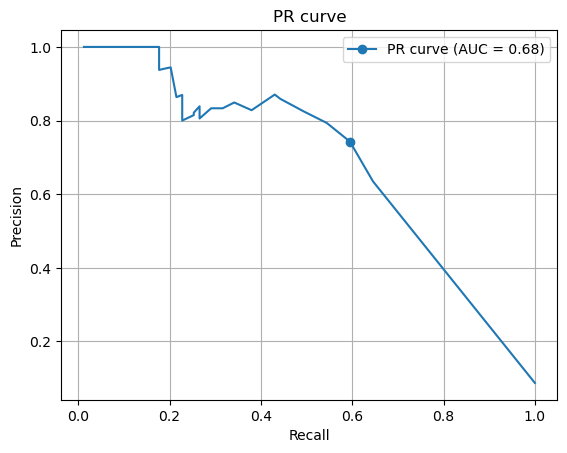

AUC：0.6760442141472942
理想の閾値：0.01935483870967742
F値（最高）：0.6607719174145631
適合率（最高）：0.7429906542056075
再現率（最高）：0.5949367088607594


In [14]:
thr_bins=100
p_score, r_score, f_score, thresholds, thr, auc = fig_pr(target_v, target_sv, thr_bins)
print('\033[31m'+f'AUC：{auc}'+'\033[0m')
print(f'理想の閾値：{thr}')
print(f'F値（最高）：{f_score.max()}')
print(f'適合率（最高）：{p_score[np.argmax(f_score)]}')
print(f'再現率（最高）：{r_score[np.argmax(f_score)]}')

## 異常度可視化

In [15]:
p, r=validate(target_v, target_sv, thr)
print(f'適合率：{p}')
print(f'再現率：{r}')

abnorm=(sv*30)**2
figure(test_v, abnorm, sv, thr)

適合率：0.7429906542056075
再現率：0.5949367088607594


(0.0, 100.0)

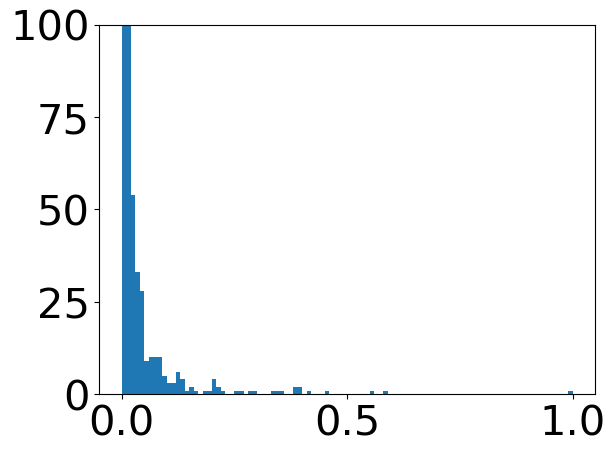

In [19]:
plt.hist(test_v['d'], bins=100)
plt.ylim(0, 100)